In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


#import models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submit = pd.read_csv('Sample_Submission.csv')

In [4]:
train.head()

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Average_Price_per_ProductType,Product_Supermarket_Sales
0,NCA29,CHUKWUDI046,NCA29_CHUKWUDI046,10.500,Low Fat,0.027276,Household,428.28,2004,Small,Cluster 1,Supermarket Type1,399.999418,8983.31
1,FDG53,CHUKWUDI049,FDG53_CHUKWUDI049,10.000,Low Fat,0.045928,Frozen Foods,345.30,2006,Medium,Cluster 1,Supermarket Type1,388.071094,4893.63
2,NCN05,CHUKWUDI045,NCN05_CHUKWUDI045,8.235,Low Fat,0.014489,Health and Hygiene,459.49,2009,NaN,Cluster 2,Supermarket Type1,367.143029,7323.80
3,NCV17,CHUKWUDI046,NCV17_CHUKWUDI046,18.850,Low Fat,0.016108,Health and Hygiene,324.41,2004,Small,Cluster 1,Supermarket Type1,367.143029,7541.85
4,FDK03,CHUKWUDI045,FDK03_CHUKWUDI045,12.600,Normal Fat,0.074070,Dairy,635.59,2009,NaN,Cluster 2,Supermarket Type1,409.504343,11445.10


In [5]:
test.head()

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Average_Price_per_ProductType
0,FDY57,CHUKWUDI013,FDY57_CHUKWUDI013,20.20,Normal Fat,0.121153,Snack Foods,243.44,1994,High,Cluster 3,Supermarket Type1,395.352190
1,FDY10,CHUKWUDI018,FDY10_CHUKWUDI018,17.60,Low Fat,0.049268,Snack Foods,282.54,2016,Medium,Cluster 3,Supermarket Type2,395.352190
2,FDO40,CHUKWUDI018,FDO40_CHUKWUDI018,17.10,Low Fat,0.032761,Frozen Foods,372.10,2016,Medium,Cluster 3,Supermarket Type2,388.071094
3,NCQ43,CHUKWUDI018,NCQ43_CHUKWUDI018,17.75,Low Fat,0.000000,Others,271.73,2016,Medium,Cluster 3,Supermarket Type2,388.607700
4,NCC07,CHUKWUDI046,NCC07_CHUKWUDI046,19.60,Low Fat,0.023951,Household,264.24,2004,Small,Cluster 1,Supermarket Type1,399.999418


In [6]:
train['Supermarket _Size'].fillna(train['Supermarket _Size'].mode()[0], inplace=True)
test['Supermarket _Size'].fillna(test['Supermarket _Size'].mode()[0], inplace=True)

In [7]:
train['Product_Weight'].fillna(train['Product_Weight'].mean(), inplace=True)
test['Product_Weight'].fillna(test['Product_Weight'].mean(), inplace=True)

In [8]:
train.drop(['Product_Supermarket_Identifier',], axis=1, inplace=True)
test.drop(['Product_Supermarket_Identifier'], axis=1, inplace=True)

In [9]:
train['PPW'] = train['Product_Weight'] * train['Product_Price']
test['PPW'] = test['Product_Weight'] * test['Product_Price']

In [10]:
train['APP'] = train['Average_Price_per_ProductType'] / train['Product_Price']
test['APP'] = test['Average_Price_per_ProductType'] / test['Product_Price']

In [11]:
train['PSV'] = train['Product_Shelf_Visibility'] * 100
test['PSV'] = test['Product_Shelf_Visibility'] * 100

In [12]:
train['PW'] = train['Product_Price'] * train['Product_Weight']
train['PV'] = train['Product_Price'] * train['Product_Shelf_Visibility']
train['PVW'] = train['Product_Price'] * train['Product_Shelf_Visibility'] * train['Product_Weight']

In [13]:
test['PW'] = test['Product_Price'] * test['Product_Weight']
test['PV'] = test['Product_Price'] * test['Product_Shelf_Visibility']
test['PVW'] = test['Product_Price'] * test['Product_Shelf_Visibility'] * test['Product_Weight']

In [14]:
train['Product_Price_sqrt'] = np.sqrt(train['Product_Price'])
test['Product_Price_sqrt'] = np.sqrt(test['Product_Price'])

In [15]:
one_hot_cols = ['Supermarket_Type', 'Supermarket _Size', 'Product_Type', 'Supermarket_Location_Type']

In [16]:
label_cols = ['Product_Identifier', 'Supermarket_Identifier', 'Product_Fat_Content']

In [17]:
train = pd.get_dummies(train, prefix_sep="_", columns=one_hot_cols)
test = pd.get_dummies(test, prefix_sep="_", columns=one_hot_cols)

In [18]:
def label_encode(df, cols):
    for col in cols:
        df[col] = df[col].factorize()[0]
        
    return df

In [19]:
train = label_encode(train, label_cols)
test = label_encode(test, label_cols)

In [27]:
train.head()

,Product_Identifier,Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Price,Supermarket_Opening_Year,Average_Price_per_ProductType,Product_Supermarket_Sales,PPW,APP,PSV,PW,PV,PVW,Product_Price_sqrt,Supermarket_Type_Grocery Store,Supermarket_Type_Supermarket Type1,Supermarket_Type_Supermarket Type2,Supermarket_Type_Supermarket Type3,Supermarket _Size_High,Supermarket _Size_Medium,Supermarket _Size_Small,Product_Type_Baking Goods,Product_Type_Breads,Product_Type_Breakfast,Product_Type_Canned,Product_Type_Dairy,Product_Type_Frozen Foods,Product_Type_Fruits and Vegetables,Product_Type_Hard Drinks,Product_Type_Health and Hygiene,Product_Type_Household,Product_Type_Meat,Product_Type_Others,Product_Type_Seafood,Product_Type_Snack Foods,Product_Type_Soft Drinks,Product_Type_Starchy Foods,Supermarket_Location_Type_Cluster 1,Supermarket_Location_Type_Cluster 2,Supermarket_Location_Type_Cluster 3,Product_Fat_Content_freq
0,0,0,10.500,0,0.027276,428.28,2004,399.999418,8983.31,4496.94000,0.933967,2.727641,4496.94000,11.681941,122.660379,20.694927,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.610888
1,1,1,10.000,0,0.045928,345.30,2006,388.071094,4893.63,3453.00000,1.123866,4.592823,3453.00000,15.859017,158.590175,18.582250,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.610888
2,2,2,8.235,0,0.014489,459.49,2009,367.143029,7323.80,3783.90015,0.799023,1.448900,3783.90015,6.657549,54.824918,21.435718,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.610888
3,3,0,18.850,0,0.016108,324.41,2004,367.143029,7541.85,6115.12850,1.131725,1.610755,6115.12850,5.225450,98.499732,18.011385,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.610888
4,4,2,12.600,1,0.074070,635.59,2009,409.504343,11445.10,8008.43400,0.644290,7.407035,8008.43400,47.078374,593.187517,25.210910,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.353039


In [28]:
test.head()

,Product_Identifier,Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Price,Supermarket_Opening_Year,Average_Price_per_ProductType,PPW,APP,PSV,PW,PV,PVW,Product_Price_sqrt,Supermarket_Type_Grocery Store,Supermarket_Type_Supermarket Type1,Supermarket_Type_Supermarket Type2,Supermarket_Type_Supermarket Type3,Supermarket _Size_High,Supermarket _Size_Medium,Supermarket _Size_Small,Product_Type_Baking Goods,Product_Type_Breads,Product_Type_Breakfast,Product_Type_Canned,Product_Type_Dairy,Product_Type_Frozen Foods,Product_Type_Fruits and Vegetables,Product_Type_Hard Drinks,Product_Type_Health and Hygiene,Product_Type_Household,Product_Type_Meat,Product_Type_Others,Product_Type_Seafood,Product_Type_Snack Foods,Product_Type_Soft Drinks,Product_Type_Starchy Foods,Supermarket_Location_Type_Cluster 1,Supermarket_Location_Type_Cluster 2,Supermarket_Location_Type_Cluster 3,Product_Fat_Content_freq
0,0,0,20.20,0,0.121153,243.44,1994,395.352190,4917.4880,1.624023,12.115333,4917.4880,29.493567,595.770051,15.602564,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.239145
1,1,1,17.60,1,0.049268,282.54,2016,395.352190,4972.7040,1.399279,4.926776,4972.7040,13.920113,244.993982,16.808926,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.404142
2,2,1,17.10,1,0.032761,372.10,2016,388.071094,6362.9100,1.042922,3.276102,6362.9100,12.190377,208.455447,19.289894,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.404142
3,3,1,17.75,1,0.000000,271.73,2016,388.607700,4823.2075,1.430124,0.000000,4823.2075,0.000000,0.000000,16.484235,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.404142
4,4,2,19.60,1,0.023951,264.24,2004,399.999418,5179.1040,1.513773,2.395115,5179.1040,6.328852,124.045492,16.255461,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.404142


In [29]:
X = train.drop('Product_Supermarket_Sales', axis=1)
y = train['Product_Supermarket_Sales']

In [30]:
def rmse(val_test, val_predict):
    acc = np.sqrt(mean_squared_error(val_test, val_predict))
    return acc

In [31]:
xgb = XGBRegressor(n_estimators=5000, max_dept=4, reg_lambda=5, random_state=101)
NFOLDS = 7
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=30)

In [32]:
scores = []
# test_pred = np.zeros(len(test))
# test_scores = 0

for fold, (tr_in, te_in) in enumerate(kf.split(X)):
    print(f'============fold{fold}=============')
    X_train, X_test = X.iloc[tr_in], X.iloc[te_in]
    y_train, y_test = y.iloc[tr_in], y.iloc[te_in]
    xgb.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=500)
    scores.append(rmse(y_test, xgb.predict(X_test)))
#     test_scores += xgb.predict(test)
#     oof_test_kf[:,fold] += xgb.predict(test)

============fold0=============
[19:47:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_dept } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:5781.33789	validation_1-rmse:5789.14746
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:4575.11523	validation_1-rmse:4636.33398
[2]	validation_0-rmse:3809.52197	validation_1-rmse:3906.64111
[3]	validation_0-rmse:3342.44946	validation_1-rmse:3479.26807
[4]	validation_0-rmse:3061.85864	validation_1-rmse:3232.03271
[5]	validation_0-rmse:2873.51025	validation_1-rmse:3134.72192
[6]	validation_0-rmse:2747.04541	validation_1-rmse:

[121]	validation_0-rmse:932.81592	validation_1-rmse:3257.06567
[122]	validation_0-rmse:926.50915	validation_1-rmse:3257.79712
[123]	validation_0-rmse:921.10388	validation_1-rmse:3257.57959
[124]	validation_0-rmse:909.00903	validation_1-rmse:3263.10132
[125]	validation_0-rmse:903.90961	validation_1-rmse:3264.23315
[126]	validation_0-rmse:901.03479	validation_1-rmse:3265.05078
[127]	validation_0-rmse:899.90143	validation_1-rmse:3265.38477
[128]	validation_0-rmse:891.54370	validation_1-rmse:3265.32251
[129]	validation_0-rmse:887.93237	validation_1-rmse:3265.54272
[130]	validation_0-rmse:876.85052	validation_1-rmse:3266.93433
[131]	validation_0-rmse:866.33820	validation_1-rmse:3267.87158
[132]	validation_0-rmse:854.56812	validation_1-rmse:3265.69556
[133]	validation_0-rmse:851.04224	validation_1-rmse:3266.43970
[134]	validation_0-rmse:846.77521	validation_1-rmse:3266.80518
[135]	validation_0-rmse:841.64520	validation_1-rmse:3267.04028
[136]	validation_0-rmse:835.48785	validation_1-rmse:326

[252]	validation_0-rmse:402.13251	validation_1-rmse:3292.39111
[253]	validation_0-rmse:400.92163	validation_1-rmse:3291.99170
[254]	validation_0-rmse:399.14578	validation_1-rmse:3292.16943
[255]	validation_0-rmse:397.01465	validation_1-rmse:3291.68530
[256]	validation_0-rmse:394.84207	validation_1-rmse:3290.98804
[257]	validation_0-rmse:392.74393	validation_1-rmse:3290.13428
[258]	validation_0-rmse:391.60577	validation_1-rmse:3290.03735
[259]	validation_0-rmse:390.38489	validation_1-rmse:3291.10107
[260]	validation_0-rmse:389.39337	validation_1-rmse:3290.32861
[261]	validation_0-rmse:386.93756	validation_1-rmse:3291.50195
[262]	validation_0-rmse:383.23105	validation_1-rmse:3291.58618
[263]	validation_0-rmse:380.66721	validation_1-rmse:3290.47241
[264]	validation_0-rmse:376.90277	validation_1-rmse:3291.02197
[265]	validation_0-rmse:372.71631	validation_1-rmse:3291.00977
[266]	validation_0-rmse:371.18893	validation_1-rmse:3290.23438
[267]	validation_0-rmse:367.55887	validation_1-rmse:329

[383]	validation_0-rmse:182.09647	validation_1-rmse:3295.36816
[384]	validation_0-rmse:181.13989	validation_1-rmse:3295.39307
[385]	validation_0-rmse:180.19443	validation_1-rmse:3295.55420
[386]	validation_0-rmse:178.83679	validation_1-rmse:3295.94995
[387]	validation_0-rmse:178.32083	validation_1-rmse:3296.35254
[388]	validation_0-rmse:177.19180	validation_1-rmse:3296.30859
[389]	validation_0-rmse:176.37247	validation_1-rmse:3296.39868
[390]	validation_0-rmse:175.62190	validation_1-rmse:3296.80322
[391]	validation_0-rmse:174.63956	validation_1-rmse:3296.76269
[392]	validation_0-rmse:172.97430	validation_1-rmse:3296.88647
[393]	validation_0-rmse:172.20145	validation_1-rmse:3297.38867
[394]	validation_0-rmse:171.69882	validation_1-rmse:3297.37769
[395]	validation_0-rmse:170.49272	validation_1-rmse:3297.31396
[396]	validation_0-rmse:169.95761	validation_1-rmse:3297.28857
[397]	validation_0-rmse:169.65376	validation_1-rmse:3297.22412
[398]	validation_0-rmse:169.35835	validation_1-rmse:329

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:4579.81445	validation_1-rmse:4497.01367
[2]	validation_0-rmse:3807.74854	validation_1-rmse:3767.35596
[3]	validation_0-rmse:3333.08569	validation_1-rmse:3361.86938
[4]	validation_0-rmse:3050.74243	validation_1-rmse:3158.55908
[5]	validation_0-rmse:2862.95019	validation_1-rmse:3063.02979
[6]	validation_0-rmse:2744.39844	validation_1-rmse:3020.42651
[7]	validation_0-rmse:2654.04053	validation_1-rmse:2986.33716
[8]	validation_0-rmse:2572.19605	validation_1-rmse:2965.38940
[9]	validation_0-rmse:2506.43115	validation_1-rmse:2980.34644
[10]	validation_0-rmse:2474.66846	validation_1-rmse:2977.13452
[11]	validation_0-rmse:2432.54272	validation_1-rmse:3005.11353
[12]	validation_0-rmse:2392.38843	validation_1-rmse:3017.68750
[13]	validation_0-rmse:2347.52441	validation_1-rmse:3011.10913
[14]	validation_0-rmse:2312.90

[129]	validation_0-rmse:854.40594	validation_1-rmse:3244.11938
[130]	validation_0-rmse:851.78509	validation_1-rmse:3244.90381
[131]	validation_0-rmse:849.06653	validation_1-rmse:3244.71338
[132]	validation_0-rmse:843.81097	validation_1-rmse:3246.60522
[133]	validation_0-rmse:838.05890	validation_1-rmse:3245.64014
[134]	validation_0-rmse:832.39062	validation_1-rmse:3248.06909
[135]	validation_0-rmse:829.78430	validation_1-rmse:3247.48853
[136]	validation_0-rmse:824.77106	validation_1-rmse:3249.27295
[137]	validation_0-rmse:823.11829	validation_1-rmse:3249.37573
[138]	validation_0-rmse:814.46161	validation_1-rmse:3251.40869
[139]	validation_0-rmse:813.25256	validation_1-rmse:3250.92334
[140]	validation_0-rmse:807.19592	validation_1-rmse:3251.13330
[141]	validation_0-rmse:806.26270	validation_1-rmse:3252.09766
[142]	validation_0-rmse:799.05463	validation_1-rmse:3253.73340
[143]	validation_0-rmse:797.63654	validation_1-rmse:3252.95581
[144]	validation_0-rmse:790.86548	validation_1-rmse:325

[260]	validation_0-rmse:378.27200	validation_1-rmse:3316.18701
[261]	validation_0-rmse:376.60962	validation_1-rmse:3316.21973
[262]	validation_0-rmse:376.26401	validation_1-rmse:3316.04761
[263]	validation_0-rmse:373.22971	validation_1-rmse:3315.28784
[264]	validation_0-rmse:370.58639	validation_1-rmse:3315.04907
[265]	validation_0-rmse:367.55130	validation_1-rmse:3315.39014
[266]	validation_0-rmse:363.71060	validation_1-rmse:3315.73291
[267]	validation_0-rmse:363.38669	validation_1-rmse:3315.90552
[268]	validation_0-rmse:359.90881	validation_1-rmse:3318.06689
[269]	validation_0-rmse:357.34518	validation_1-rmse:3318.55420
[270]	validation_0-rmse:356.19788	validation_1-rmse:3318.23364
[271]	validation_0-rmse:353.78861	validation_1-rmse:3318.60644
[272]	validation_0-rmse:352.83240	validation_1-rmse:3318.70630
[273]	validation_0-rmse:350.83484	validation_1-rmse:3319.12695
[274]	validation_0-rmse:349.18369	validation_1-rmse:3318.70703
[275]	validation_0-rmse:346.69235	validation_1-rmse:331

[391]	validation_0-rmse:176.57848	validation_1-rmse:3322.91382
[392]	validation_0-rmse:175.78497	validation_1-rmse:3323.69971
[393]	validation_0-rmse:174.86351	validation_1-rmse:3323.96289
[394]	validation_0-rmse:174.04240	validation_1-rmse:3323.86377
[395]	validation_0-rmse:173.34128	validation_1-rmse:3323.93311
[396]	validation_0-rmse:172.66962	validation_1-rmse:3324.44385
[397]	validation_0-rmse:171.58846	validation_1-rmse:3324.13892
[398]	validation_0-rmse:170.64798	validation_1-rmse:3324.38647
[399]	validation_0-rmse:169.54730	validation_1-rmse:3324.51489
[400]	validation_0-rmse:168.11192	validation_1-rmse:3324.83301
[401]	validation_0-rmse:166.96283	validation_1-rmse:3325.11572
[402]	validation_0-rmse:166.23955	validation_1-rmse:3324.91138
[403]	validation_0-rmse:165.48946	validation_1-rmse:3324.90503
[404]	validation_0-rmse:164.41859	validation_1-rmse:3325.31250
[405]	validation_0-rmse:163.45827	validation_1-rmse:3325.76514
[406]	validation_0-rmse:163.05832	validation_1-rmse:332

[2]	validation_0-rmse:3794.54394	validation_1-rmse:3985.29810
[3]	validation_0-rmse:3326.90625	validation_1-rmse:3533.65649
[4]	validation_0-rmse:3053.19873	validation_1-rmse:3281.11499
[5]	validation_0-rmse:2874.74829	validation_1-rmse:3144.36450
[6]	validation_0-rmse:2743.28564	validation_1-rmse:3077.91968
[7]	validation_0-rmse:2661.51636	validation_1-rmse:3048.87573
[8]	validation_0-rmse:2589.59961	validation_1-rmse:3027.65503
[9]	validation_0-rmse:2517.50513	validation_1-rmse:3011.17065
[10]	validation_0-rmse:2462.59961	validation_1-rmse:3012.58887
[11]	validation_0-rmse:2424.56128	validation_1-rmse:3008.61206
[12]	validation_0-rmse:2368.06177	validation_1-rmse:2989.08057
[13]	validation_0-rmse:2346.78760	validation_1-rmse:2989.63867
[14]	validation_0-rmse:2327.00903	validation_1-rmse:2992.12012
[15]	validation_0-rmse:2291.90356	validation_1-rmse:3009.45923
[16]	validation_0-rmse:2278.38818	validation_1-rmse:3007.93408
[17]	validation_0-rmse:2247.31860	validation_1-rmse:3013.82422


[133]	validation_0-rmse:860.31329	validation_1-rmse:3235.86206
[134]	validation_0-rmse:858.73596	validation_1-rmse:3237.04858
[135]	validation_0-rmse:851.41833	validation_1-rmse:3236.45019
[136]	validation_0-rmse:848.20868	validation_1-rmse:3236.40039
[137]	validation_0-rmse:845.64807	validation_1-rmse:3237.00391
[138]	validation_0-rmse:841.13818	validation_1-rmse:3238.21387
[139]	validation_0-rmse:836.71137	validation_1-rmse:3237.18433
[140]	validation_0-rmse:830.46869	validation_1-rmse:3240.25171
[141]	validation_0-rmse:828.07501	validation_1-rmse:3240.22534
[142]	validation_0-rmse:823.11505	validation_1-rmse:3241.30737
[143]	validation_0-rmse:812.06274	validation_1-rmse:3242.62231
[144]	validation_0-rmse:810.23688	validation_1-rmse:3243.25781
[145]	validation_0-rmse:806.06012	validation_1-rmse:3243.29272
[146]	validation_0-rmse:797.11700	validation_1-rmse:3241.20264
[147]	validation_0-rmse:795.20129	validation_1-rmse:3240.14795
[148]	validation_0-rmse:789.75256	validation_1-rmse:324

[264]	validation_0-rmse:378.09842	validation_1-rmse:3270.36523
[265]	validation_0-rmse:376.55832	validation_1-rmse:3270.27026
[266]	validation_0-rmse:376.00855	validation_1-rmse:3271.27905
[267]	validation_0-rmse:373.72733	validation_1-rmse:3272.37671
[268]	validation_0-rmse:369.18277	validation_1-rmse:3272.99707
[269]	validation_0-rmse:365.60007	validation_1-rmse:3273.46729
[270]	validation_0-rmse:361.84644	validation_1-rmse:3272.45068
[271]	validation_0-rmse:357.89227	validation_1-rmse:3272.43237
[272]	validation_0-rmse:355.34561	validation_1-rmse:3272.56006
[273]	validation_0-rmse:353.77902	validation_1-rmse:3272.69531
[274]	validation_0-rmse:352.58066	validation_1-rmse:3273.04004
[275]	validation_0-rmse:351.13080	validation_1-rmse:3274.48633
[276]	validation_0-rmse:348.73105	validation_1-rmse:3273.92456
[277]	validation_0-rmse:347.04395	validation_1-rmse:3273.71436
[278]	validation_0-rmse:343.92636	validation_1-rmse:3274.89160
[279]	validation_0-rmse:342.12198	validation_1-rmse:327

[395]	validation_0-rmse:172.21832	validation_1-rmse:3281.65259
[396]	validation_0-rmse:171.41353	validation_1-rmse:3281.71191
[397]	validation_0-rmse:169.55241	validation_1-rmse:3281.74927
[398]	validation_0-rmse:168.14571	validation_1-rmse:3281.83838
[399]	validation_0-rmse:167.38058	validation_1-rmse:3281.81421
[400]	validation_0-rmse:166.47501	validation_1-rmse:3282.07202
[401]	validation_0-rmse:165.77498	validation_1-rmse:3282.66357
[402]	validation_0-rmse:165.31662	validation_1-rmse:3282.41480
[403]	validation_0-rmse:164.87788	validation_1-rmse:3282.03296
[404]	validation_0-rmse:164.53554	validation_1-rmse:3282.22070
[405]	validation_0-rmse:163.31038	validation_1-rmse:3281.77979
[406]	validation_0-rmse:161.80231	validation_1-rmse:3281.97192
[407]	validation_0-rmse:161.13170	validation_1-rmse:3281.74731
[408]	validation_0-rmse:160.26938	validation_1-rmse:3281.50830
[409]	validation_0-rmse:159.27318	validation_1-rmse:3281.08154
[410]	validation_0-rmse:158.36507	validation_1-rmse:328

[2]	validation_0-rmse:3835.82788	validation_1-rmse:3399.47607
[3]	validation_0-rmse:3357.87964	validation_1-rmse:3046.10547
[4]	validation_0-rmse:3075.74072	validation_1-rmse:2872.81348
[5]	validation_0-rmse:2876.83960	validation_1-rmse:2805.36670
[6]	validation_0-rmse:2753.76099	validation_1-rmse:2805.39746
[7]	validation_0-rmse:2650.35083	validation_1-rmse:2829.84277
[8]	validation_0-rmse:2586.83374	validation_1-rmse:2836.06909
[9]	validation_0-rmse:2524.31030	validation_1-rmse:2865.94849
[10]	validation_0-rmse:2466.08203	validation_1-rmse:2902.93774
[11]	validation_0-rmse:2419.00049	validation_1-rmse:2907.46729
[12]	validation_0-rmse:2363.70996	validation_1-rmse:2927.50928
[13]	validation_0-rmse:2311.97852	validation_1-rmse:2943.86060
[14]	validation_0-rmse:2267.53320	validation_1-rmse:2957.30664
[15]	validation_0-rmse:2215.14478	validation_1-rmse:2968.10352
[16]	validation_0-rmse:2192.77881	validation_1-rmse:2975.50439
[17]	validation_0-rmse:2162.32739	validation_1-rmse:2969.31885


[133]	validation_0-rmse:802.54102	validation_1-rmse:3227.35913
[134]	validation_0-rmse:798.95673	validation_1-rmse:3229.87280
[135]	validation_0-rmse:797.56067	validation_1-rmse:3229.81738
[136]	validation_0-rmse:793.92847	validation_1-rmse:3229.57788
[137]	validation_0-rmse:792.50067	validation_1-rmse:3228.78980
[138]	validation_0-rmse:785.54333	validation_1-rmse:3228.70728
[139]	validation_0-rmse:777.68140	validation_1-rmse:3232.66089
[140]	validation_0-rmse:772.06158	validation_1-rmse:3232.73706
[141]	validation_0-rmse:768.01276	validation_1-rmse:3234.12573
[142]	validation_0-rmse:764.06860	validation_1-rmse:3235.49390
[143]	validation_0-rmse:761.18323	validation_1-rmse:3235.41504
[144]	validation_0-rmse:759.19977	validation_1-rmse:3235.23584
[145]	validation_0-rmse:754.20715	validation_1-rmse:3234.58813
[146]	validation_0-rmse:752.55786	validation_1-rmse:3233.82275
[147]	validation_0-rmse:748.38806	validation_1-rmse:3235.76196
[148]	validation_0-rmse:744.63281	validation_1-rmse:323

[264]	validation_0-rmse:352.63956	validation_1-rmse:3313.11133
[265]	validation_0-rmse:351.29993	validation_1-rmse:3313.01294
[266]	validation_0-rmse:349.58035	validation_1-rmse:3313.25488
[267]	validation_0-rmse:348.18863	validation_1-rmse:3313.22583
[268]	validation_0-rmse:344.09979	validation_1-rmse:3313.59131
[269]	validation_0-rmse:341.64459	validation_1-rmse:3314.26074
[270]	validation_0-rmse:337.91242	validation_1-rmse:3315.67749
[271]	validation_0-rmse:334.81747	validation_1-rmse:3317.53247
[272]	validation_0-rmse:332.72018	validation_1-rmse:3318.08252
[273]	validation_0-rmse:331.03598	validation_1-rmse:3317.58545
[274]	validation_0-rmse:329.57504	validation_1-rmse:3317.30835
[275]	validation_0-rmse:328.36700	validation_1-rmse:3318.01392
[276]	validation_0-rmse:328.13800	validation_1-rmse:3318.11938
[277]	validation_0-rmse:326.67868	validation_1-rmse:3318.42749
[278]	validation_0-rmse:325.51291	validation_1-rmse:3318.52539
[279]	validation_0-rmse:324.13452	validation_1-rmse:331

[395]	validation_0-rmse:165.23704	validation_1-rmse:3333.83179
[396]	validation_0-rmse:164.05428	validation_1-rmse:3334.17383
[397]	validation_0-rmse:162.77141	validation_1-rmse:3334.23144
[398]	validation_0-rmse:161.27820	validation_1-rmse:3334.58472
[399]	validation_0-rmse:160.21669	validation_1-rmse:3335.07202
[400]	validation_0-rmse:159.97122	validation_1-rmse:3335.16187
[401]	validation_0-rmse:159.59045	validation_1-rmse:3335.03369
[402]	validation_0-rmse:158.37277	validation_1-rmse:3335.33618
[403]	validation_0-rmse:157.70836	validation_1-rmse:3335.57495
[404]	validation_0-rmse:156.05109	validation_1-rmse:3335.85620
[405]	validation_0-rmse:155.58333	validation_1-rmse:3335.55640
[406]	validation_0-rmse:155.27129	validation_1-rmse:3335.54517
[407]	validation_0-rmse:154.12988	validation_1-rmse:3336.02026
[408]	validation_0-rmse:153.39407	validation_1-rmse:3335.83350
[409]	validation_0-rmse:152.72778	validation_1-rmse:3335.60059
[410]	validation_0-rmse:152.05446	validation_1-rmse:333

[9]	validation_0-rmse:2456.92383	validation_1-rmse:3285.95703
[10]	validation_0-rmse:2411.53980	validation_1-rmse:3298.46680
[11]	validation_0-rmse:2371.04346	validation_1-rmse:3296.66699
[12]	validation_0-rmse:2345.43823	validation_1-rmse:3285.72803
[13]	validation_0-rmse:2311.53735	validation_1-rmse:3290.39136
[14]	validation_0-rmse:2280.00635	validation_1-rmse:3302.39331
[15]	validation_0-rmse:2234.49170	validation_1-rmse:3303.09546
[16]	validation_0-rmse:2210.64380	validation_1-rmse:3304.74194
[17]	validation_0-rmse:2171.60230	validation_1-rmse:3312.60449
[18]	validation_0-rmse:2140.95581	validation_1-rmse:3322.34497
[19]	validation_0-rmse:2102.02466	validation_1-rmse:3322.35815
[20]	validation_0-rmse:2074.29590	validation_1-rmse:3325.73731
[21]	validation_0-rmse:2054.71167	validation_1-rmse:3326.92822
[22]	validation_0-rmse:2029.43579	validation_1-rmse:3323.91162
[23]	validation_0-rmse:1984.42212	validation_1-rmse:3335.36475
[24]	validation_0-rmse:1971.54541	validation_1-rmse:3342

[139]	validation_0-rmse:796.43945	validation_1-rmse:3466.65723
[140]	validation_0-rmse:788.48242	validation_1-rmse:3469.65454
[141]	validation_0-rmse:785.31903	validation_1-rmse:3468.87524
[142]	validation_0-rmse:780.12494	validation_1-rmse:3468.84009
[143]	validation_0-rmse:777.50671	validation_1-rmse:3468.37500
[144]	validation_0-rmse:773.40546	validation_1-rmse:3469.75977
[145]	validation_0-rmse:766.25037	validation_1-rmse:3470.94189
[146]	validation_0-rmse:761.76422	validation_1-rmse:3475.03809
[147]	validation_0-rmse:759.56055	validation_1-rmse:3475.01196
[148]	validation_0-rmse:754.60492	validation_1-rmse:3475.76978
[149]	validation_0-rmse:746.51654	validation_1-rmse:3475.36450
[150]	validation_0-rmse:740.89838	validation_1-rmse:3475.81323
[151]	validation_0-rmse:734.52801	validation_1-rmse:3475.42603
[152]	validation_0-rmse:730.84137	validation_1-rmse:3476.61938
[153]	validation_0-rmse:723.33777	validation_1-rmse:3477.51660
[154]	validation_0-rmse:717.68280	validation_1-rmse:347

[270]	validation_0-rmse:353.61218	validation_1-rmse:3520.56812
[271]	validation_0-rmse:351.96729	validation_1-rmse:3521.66284
[272]	validation_0-rmse:348.70993	validation_1-rmse:3522.57812
[273]	validation_0-rmse:347.15784	validation_1-rmse:3521.23511
[274]	validation_0-rmse:343.68576	validation_1-rmse:3520.62573
[275]	validation_0-rmse:340.81574	validation_1-rmse:3520.96460
[276]	validation_0-rmse:340.31256	validation_1-rmse:3521.24658
[277]	validation_0-rmse:339.03113	validation_1-rmse:3521.09253
[278]	validation_0-rmse:336.81647	validation_1-rmse:3522.40942
[279]	validation_0-rmse:334.45322	validation_1-rmse:3522.82105
[280]	validation_0-rmse:331.16437	validation_1-rmse:3522.38721
[281]	validation_0-rmse:328.94232	validation_1-rmse:3522.69434
[282]	validation_0-rmse:327.14688	validation_1-rmse:3523.11890
[283]	validation_0-rmse:325.68665	validation_1-rmse:3524.02270
[284]	validation_0-rmse:323.75220	validation_1-rmse:3523.21924
[285]	validation_0-rmse:322.38568	validation_1-rmse:352

[401]	validation_0-rmse:168.31805	validation_1-rmse:3543.52563
[402]	validation_0-rmse:167.63689	validation_1-rmse:3543.75122
[403]	validation_0-rmse:166.91502	validation_1-rmse:3543.93213
[404]	validation_0-rmse:166.43086	validation_1-rmse:3544.10474
[405]	validation_0-rmse:165.72188	validation_1-rmse:3544.15601
[406]	validation_0-rmse:165.13083	validation_1-rmse:3544.08716
[407]	validation_0-rmse:164.62799	validation_1-rmse:3544.23389
[408]	validation_0-rmse:164.46455	validation_1-rmse:3544.29443
[409]	validation_0-rmse:163.95213	validation_1-rmse:3544.55225
[410]	validation_0-rmse:163.48263	validation_1-rmse:3544.49487
[411]	validation_0-rmse:162.40730	validation_1-rmse:3544.77563
[412]	validation_0-rmse:160.88893	validation_1-rmse:3544.98682
[413]	validation_0-rmse:160.62602	validation_1-rmse:3545.18530
[414]	validation_0-rmse:159.44119	validation_1-rmse:3545.67285
[415]	validation_0-rmse:158.30231	validation_1-rmse:3545.34106
[416]	validation_0-rmse:157.63460	validation_1-rmse:354

[8]	validation_0-rmse:2574.68970	validation_1-rmse:3019.42895
[9]	validation_0-rmse:2529.97437	validation_1-rmse:3007.85034
[10]	validation_0-rmse:2483.27466	validation_1-rmse:3000.05859
[11]	validation_0-rmse:2448.55957	validation_1-rmse:2996.22754
[12]	validation_0-rmse:2407.73950	validation_1-rmse:2990.16406
[13]	validation_0-rmse:2363.60107	validation_1-rmse:2997.29126
[14]	validation_0-rmse:2321.80298	validation_1-rmse:3016.17773
[15]	validation_0-rmse:2300.20068	validation_1-rmse:3020.48267
[16]	validation_0-rmse:2271.37500	validation_1-rmse:3024.37988
[17]	validation_0-rmse:2239.16724	validation_1-rmse:3028.46436
[18]	validation_0-rmse:2193.70850	validation_1-rmse:3039.02002
[19]	validation_0-rmse:2172.74902	validation_1-rmse:3036.08154
[20]	validation_0-rmse:2164.34204	validation_1-rmse:3041.18384
[21]	validation_0-rmse:2145.17163	validation_1-rmse:3049.66040
[22]	validation_0-rmse:2128.31201	validation_1-rmse:3059.74243
[23]	validation_0-rmse:2106.82007	validation_1-rmse:3061.

[138]	validation_0-rmse:874.38666	validation_1-rmse:3172.24878
[139]	validation_0-rmse:871.76758	validation_1-rmse:3172.23975
[140]	validation_0-rmse:862.72949	validation_1-rmse:3171.98950
[141]	validation_0-rmse:861.14545	validation_1-rmse:3172.68457
[142]	validation_0-rmse:858.77148	validation_1-rmse:3174.37646
[143]	validation_0-rmse:855.32800	validation_1-rmse:3176.41016
[144]	validation_0-rmse:849.77362	validation_1-rmse:3176.17969
[145]	validation_0-rmse:841.19824	validation_1-rmse:3173.73511
[146]	validation_0-rmse:835.31384	validation_1-rmse:3172.00513
[147]	validation_0-rmse:833.86389	validation_1-rmse:3171.87720
[148]	validation_0-rmse:828.42987	validation_1-rmse:3172.59619
[149]	validation_0-rmse:821.48309	validation_1-rmse:3172.44019
[150]	validation_0-rmse:812.92725	validation_1-rmse:3172.96753
[151]	validation_0-rmse:807.50702	validation_1-rmse:3169.52270
[152]	validation_0-rmse:805.97662	validation_1-rmse:3170.11231
[153]	validation_0-rmse:801.64685	validation_1-rmse:317

[269]	validation_0-rmse:364.63855	validation_1-rmse:3239.44507
[270]	validation_0-rmse:361.14481	validation_1-rmse:3240.42676
[271]	validation_0-rmse:359.61389	validation_1-rmse:3240.72681
[272]	validation_0-rmse:357.13147	validation_1-rmse:3242.30078
[273]	validation_0-rmse:354.32269	validation_1-rmse:3242.63818
[274]	validation_0-rmse:353.44138	validation_1-rmse:3243.23242
[275]	validation_0-rmse:351.55334	validation_1-rmse:3243.51367
[276]	validation_0-rmse:348.95114	validation_1-rmse:3243.63696
[277]	validation_0-rmse:342.23804	validation_1-rmse:3242.67139
[278]	validation_0-rmse:338.73151	validation_1-rmse:3242.89746
[279]	validation_0-rmse:337.14612	validation_1-rmse:3242.99097
[280]	validation_0-rmse:333.26965	validation_1-rmse:3242.36792
[281]	validation_0-rmse:331.43289	validation_1-rmse:3242.13672
[282]	validation_0-rmse:327.42346	validation_1-rmse:3243.29053
[283]	validation_0-rmse:324.16531	validation_1-rmse:3243.84766
[284]	validation_0-rmse:322.41125	validation_1-rmse:324

[400]	validation_0-rmse:163.88994	validation_1-rmse:3257.97461
[401]	validation_0-rmse:163.65845	validation_1-rmse:3258.05054
[402]	validation_0-rmse:163.17520	validation_1-rmse:3258.14893
[403]	validation_0-rmse:162.45962	validation_1-rmse:3258.10693
[404]	validation_0-rmse:160.91754	validation_1-rmse:3258.41211
[405]	validation_0-rmse:160.06792	validation_1-rmse:3258.33960
[406]	validation_0-rmse:159.49841	validation_1-rmse:3258.59229
[407]	validation_0-rmse:159.19910	validation_1-rmse:3258.60986
[408]	validation_0-rmse:158.61520	validation_1-rmse:3258.89697
[409]	validation_0-rmse:157.74684	validation_1-rmse:3258.91382
[410]	validation_0-rmse:157.16266	validation_1-rmse:3258.90088
[411]	validation_0-rmse:156.33479	validation_1-rmse:3258.66724
[412]	validation_0-rmse:155.44321	validation_1-rmse:3258.83252
[413]	validation_0-rmse:154.74924	validation_1-rmse:3258.88940
[414]	validation_0-rmse:153.97954	validation_1-rmse:3258.84009
[415]	validation_0-rmse:153.35043	validation_1-rmse:325

[7]	validation_0-rmse:2663.64673	validation_1-rmse:3071.51685
[8]	validation_0-rmse:2596.69043	validation_1-rmse:3069.68652
[9]	validation_0-rmse:2519.98901	validation_1-rmse:3061.95825
[10]	validation_0-rmse:2446.10693	validation_1-rmse:3055.68384
[11]	validation_0-rmse:2383.53809	validation_1-rmse:3046.04663
[12]	validation_0-rmse:2337.00513	validation_1-rmse:3039.87622
[13]	validation_0-rmse:2308.29492	validation_1-rmse:3046.03149
[14]	validation_0-rmse:2289.28223	validation_1-rmse:3043.40869
[15]	validation_0-rmse:2271.50366	validation_1-rmse:3037.02856
[16]	validation_0-rmse:2244.34180	validation_1-rmse:3038.84644
[17]	validation_0-rmse:2219.61328	validation_1-rmse:3036.95825
[18]	validation_0-rmse:2198.58911	validation_1-rmse:3046.48486
[19]	validation_0-rmse:2178.70703	validation_1-rmse:3053.77270
[20]	validation_0-rmse:2160.54517	validation_1-rmse:3057.48462
[21]	validation_0-rmse:2139.51587	validation_1-rmse:3062.61890
[22]	validation_0-rmse:2105.35425	validation_1-rmse:3067.0

[137]	validation_0-rmse:844.48193	validation_1-rmse:3281.93823
[138]	validation_0-rmse:843.93781	validation_1-rmse:3281.63306
[139]	validation_0-rmse:837.30383	validation_1-rmse:3284.21753
[140]	validation_0-rmse:830.90192	validation_1-rmse:3285.05908
[141]	validation_0-rmse:828.16028	validation_1-rmse:3285.25977
[142]	validation_0-rmse:816.53772	validation_1-rmse:3281.53540
[143]	validation_0-rmse:812.15515	validation_1-rmse:3282.13037
[144]	validation_0-rmse:805.90131	validation_1-rmse:3281.29394
[145]	validation_0-rmse:801.30737	validation_1-rmse:3282.66748
[146]	validation_0-rmse:797.72022	validation_1-rmse:3282.85010
[147]	validation_0-rmse:793.10791	validation_1-rmse:3284.28467
[148]	validation_0-rmse:787.89630	validation_1-rmse:3285.93311
[149]	validation_0-rmse:778.46661	validation_1-rmse:3290.47827
[150]	validation_0-rmse:772.96973	validation_1-rmse:3291.23315
[151]	validation_0-rmse:768.90576	validation_1-rmse:3293.76733
[152]	validation_0-rmse:762.01642	validation_1-rmse:329

[268]	validation_0-rmse:343.71948	validation_1-rmse:3358.62720
[269]	validation_0-rmse:342.72400	validation_1-rmse:3358.38696
[270]	validation_0-rmse:340.38773	validation_1-rmse:3359.80615
[271]	validation_0-rmse:337.88522	validation_1-rmse:3360.22314
[272]	validation_0-rmse:336.61618	validation_1-rmse:3359.86792
[273]	validation_0-rmse:334.71069	validation_1-rmse:3360.54736
[274]	validation_0-rmse:333.02447	validation_1-rmse:3360.25269
[275]	validation_0-rmse:331.77792	validation_1-rmse:3359.90332
[276]	validation_0-rmse:329.14877	validation_1-rmse:3359.62622
[277]	validation_0-rmse:327.47436	validation_1-rmse:3360.43433
[278]	validation_0-rmse:326.69574	validation_1-rmse:3360.38525
[279]	validation_0-rmse:324.84912	validation_1-rmse:3360.61206
[280]	validation_0-rmse:323.89316	validation_1-rmse:3360.71411
[281]	validation_0-rmse:320.54324	validation_1-rmse:3361.27197
[282]	validation_0-rmse:318.97000	validation_1-rmse:3361.73462
[283]	validation_0-rmse:316.74899	validation_1-rmse:336

[399]	validation_0-rmse:161.06996	validation_1-rmse:3381.16309
[400]	validation_0-rmse:159.51270	validation_1-rmse:3381.15161
[401]	validation_0-rmse:158.59480	validation_1-rmse:3381.18799
[402]	validation_0-rmse:156.72806	validation_1-rmse:3381.38306
[403]	validation_0-rmse:156.06529	validation_1-rmse:3381.64966
[404]	validation_0-rmse:154.77300	validation_1-rmse:3382.17993
[405]	validation_0-rmse:154.39114	validation_1-rmse:3382.26367
[406]	validation_0-rmse:153.25008	validation_1-rmse:3382.20410
[407]	validation_0-rmse:152.32286	validation_1-rmse:3382.51099
[408]	validation_0-rmse:151.74149	validation_1-rmse:3382.68384
[409]	validation_0-rmse:151.23311	validation_1-rmse:3382.61938
[410]	validation_0-rmse:150.46086	validation_1-rmse:3382.81104
[411]	validation_0-rmse:148.50682	validation_1-rmse:3383.06055
[412]	validation_0-rmse:147.64082	validation_1-rmse:3382.94897
[413]	validation_0-rmse:146.76794	validation_1-rmse:3382.97583
[414]	validation_0-rmse:145.89670	validation_1-rmse:338

In [61]:
print(scores.min())

-2443.7755291456656


In [34]:
kfold_pred = xgb.predict(test)

In [36]:
submit['Product_Supermarket_Sales'] = kfold_pred

In [37]:
submit.to_csv('kfold.csv', index=False)

# stacking

In [38]:
train.head()

,Product_Identifier,Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Price,Supermarket_Opening_Year,Average_Price_per_ProductType,Product_Supermarket_Sales,PPW,APP,PSV,PW,PV,PVW,Product_Price_sqrt,Supermarket_Type_Grocery Store,Supermarket_Type_Supermarket Type1,Supermarket_Type_Supermarket Type2,Supermarket_Type_Supermarket Type3,Supermarket _Size_High,Supermarket _Size_Medium,Supermarket _Size_Small,Product_Type_Baking Goods,Product_Type_Breads,Product_Type_Breakfast,Product_Type_Canned,Product_Type_Dairy,Product_Type_Frozen Foods,Product_Type_Fruits and Vegetables,Product_Type_Hard Drinks,Product_Type_Health and Hygiene,Product_Type_Household,Product_Type_Meat,Product_Type_Others,Product_Type_Seafood,Product_Type_Snack Foods,Product_Type_Soft Drinks,Product_Type_Starchy Foods,Supermarket_Location_Type_Cluster 1,Supermarket_Location_Type_Cluster 2,Supermarket_Location_Type_Cluster 3,Product_Fat_Content_freq
0,0,0,10.500,0,0.027276,428.28,2004,399.999418,8983.31,4496.94000,0.933967,2.727641,4496.94000,11.681941,122.660379,20.694927,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.610888
1,1,1,10.000,0,0.045928,345.30,2006,388.071094,4893.63,3453.00000,1.123866,4.592823,3453.00000,15.859017,158.590175,18.582250,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.610888
2,2,2,8.235,0,0.014489,459.49,2009,367.143029,7323.80,3783.90015,0.799023,1.448900,3783.90015,6.657549,54.824918,21.435718,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.610888
3,3,0,18.850,0,0.016108,324.41,2004,367.143029,7541.85,6115.12850,1.131725,1.610755,6115.12850,5.225450,98.499732,18.011385,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.610888
4,4,2,12.600,1,0.074070,635.59,2009,409.504343,11445.10,8008.43400,0.644290,7.407035,8008.43400,47.078374,593.187517,25.210910,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.353039


In [50]:
def get_models():
    models = dict()
    models['knn'] = KNeighborsRegressor()
    models['rfc'] = RandomForestRegressor()
    models['xgb'] = XGBRegressor()
    
    return models

In [51]:
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    
    return scores

In [56]:
def get_stacking():
    level0 = list()
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('rfc', RandomForestRegressor()))
    level0.append(('xgb', XGBRegressor()))
    
    level1 = LinearRegression()
    
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    
    return model

In [53]:
def get_models_final():
    models = dict()
    models['knn'] = KNeighborsRegressor()
    models['rfc'] = RandomForestRegressor()
    models['xgb'] = XGBRegressor()
    models['stacking'] = get_stacking()
    
    return models

In [54]:
#models without stacking

models = get_models()
results, names = list(), list()

print("Errors of the model without stacking")

for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
    print('>%s %.3f(%.3f)' %(name, np.mean(scores), np.std(scores)))

Errors of the model without stacking
>knn -3214.274(149.089)
>rfc -2245.371(102.721)
>xgb -2401.879(107.290)


In [57]:
#models with stacking

models = get_models_final()

results, names = list(), list()

print("Errors of the model with stacking")

for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
    print('>%s %.3f(%.3f)' %(name, np.mean(scores), np.std(scores)))

Errors of the model with stacking
>knn -3214.274(149.089)
>rfc -2238.961(100.933)
>xgb -2401.879(107.290)
>stacking -2260.730(99.561)


In [63]:
#final model for prediction

level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('rfc', RandomForestRegressor()))
level0.append(('xgb', XGBRegressor()))

level1 = LinearRegression()

final_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [65]:
final_model.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('knn', KNeighborsRegressor()),
                              ('rfc', RandomForestRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=Non

In [66]:
pred = final_model.predict(X_test)

In [67]:
print(np.sqrt(mean_squared_error(y_test, pred)))

3156.4931990032887


In [68]:
final_pred = final_model.predict(test)

In [108]:
test.shape

(1996, 21)

In [109]:
final_pred.shape

(1996,)

In [110]:
submit.Product_Supermarket_Sales.shape

(1996,)

In [69]:
submit['Product_Supermarket_Sales'] = final_pred

In [70]:
submit.to_csv('stack_pred_2.csv', index=False)

In [90]:
rfc_model = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_split=9, max_leaf_nodes=55)

In [91]:
rfc_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_leaf_nodes=55, min_samples_split=9,
                      n_estimators=1000)

In [92]:
rfc_pred = rfc_model.predict(X_test)

In [93]:
np.sqrt(mean_squared_error(y_test, rfc_pred))

3073.0769262840195

In [94]:
rfc_final = rfc_model.predict(test)

In [95]:
submit['Product_Supermarket_Sales'] = rfc_final

In [96]:
submit.to_csv('rfc_model.csv', index=False)

In [131]:
cat_model = CatBoostRegressor(learning_rate=0.09, iterations=100, depth=4)

In [132]:
cat_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=500, use_best_model=True)

0:	learn: 4262.4940955	test: 4262.4940955	test1: 4394.3115406	best: 4394.3115406 (0)	total: 2.5ms	remaining: 248ms
1:	learn: 4085.2195915	test: 4085.2195915	test1: 4220.1888609	best: 4220.1888609 (1)	total: 4.71ms	remaining: 231ms
2:	learn: 3929.1523317	test: 3929.1523317	test1: 4064.6780422	best: 4064.6780422 (2)	total: 6.89ms	remaining: 223ms
3:	learn: 3789.5943831	test: 3789.5943831	test1: 3929.9480774	best: 3929.9480774 (3)	total: 9.14ms	remaining: 219ms
4:	learn: 3669.4074938	test: 3669.4074938	test1: 3812.4116837	best: 3812.4116837 (4)	total: 11.3ms	remaining: 215ms
5:	learn: 3575.4731094	test: 3575.4731094	test1: 3718.4302357	best: 3718.4302357 (5)	total: 13.6ms	remaining: 213ms
6:	learn: 3490.2222307	test: 3490.2222307	test1: 3636.3796862	best: 3636.3796862 (6)	total: 15.9ms	remaining: 211ms
7:	learn: 3413.9429489	test: 3413.9429489	test1: 3560.8391570	best: 3560.8391570 (7)	total: 18.5ms	remaining: 212ms
8:	learn: 3344.2249297	test: 3344.2249297	test1: 3491.5808756	best: 3491.

77:	learn: 2794.9894089	test: 2794.9894089	test1: 3048.2579104	best: 3046.4608801 (63)	total: 169ms	remaining: 47.7ms
78:	learn: 2794.0550159	test: 2794.0550159	test1: 3048.2723015	best: 3046.4608801 (63)	total: 173ms	remaining: 46ms
79:	learn: 2792.6428280	test: 2792.6428280	test1: 3049.0738197	best: 3046.4608801 (63)	total: 176ms	remaining: 44ms
80:	learn: 2790.8678514	test: 2790.8678514	test1: 3048.9563603	best: 3046.4608801 (63)	total: 179ms	remaining: 41.9ms
81:	learn: 2789.9876081	test: 2789.9876081	test1: 3049.2213063	best: 3046.4608801 (63)	total: 181ms	remaining: 39.7ms
82:	learn: 2788.5844436	test: 2788.5844436	test1: 3048.8652571	best: 3046.4608801 (63)	total: 184ms	remaining: 37.6ms
83:	learn: 2786.0887491	test: 2786.0887491	test1: 3050.7845502	best: 3046.4608801 (63)	total: 186ms	remaining: 35.4ms
84:	learn: 2784.1453568	test: 2784.1453568	test1: 3052.2359695	best: 3046.4608801 (63)	total: 189ms	remaining: 33.3ms
85:	learn: 2783.3981987	test: 2783.3981987	test1: 3051.77545

In [133]:
cat_final = cat_model.predict(test)

In [134]:
submit['Product_Supermarket_Sales'] = cat_final

In [135]:
submit.to_csv('cat_model.csv', index=False)

In [248]:
xgb_model = XGBRegressor(learning_rate =0.08, n_estimators=45, max_depth=3)

In [249]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=45, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [250]:
xgb_pred = xgb_model.predict(X_test)

In [251]:
np.sqrt(mean_squared_error(y_test, xgb_pred))

3083.681424504249

In [252]:
xgb_final = xgb_model.predict(test)

In [253]:
submit['Product_Supermarket_Sales'] = xgb_final

In [254]:
submit.to_csv('xgb_model.csv', index=False)

In [255]:
lin_model = LinearRegression()

In [256]:
lin_model.fit(X_train, y_train)

LinearRegression()

In [257]:
lin_pred = lin_model.predict(X_test)

In [258]:
np.sqrt(mean_squared_error(y_test, lin_pred))

3114.781017488

In [260]:
lin_final = lin_model.predict(test)

In [261]:
submit['Product_Supermarket_Sales'] = lin_final

In [262]:
submit.to_csv('lin_model.csv', index=False)

# trying feature importance

In [288]:
xgb_model_2 = XGBRegressor(learning_rate =0.09, n_estimators=40, max_depth=3, reg_lambda=9)

In [289]:
xgb_model_2.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=300)

[0]	validation_0-rmse:7028.22412	validation_1-rmse:7220.10352
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 300 rounds.
[1]	validation_0-rmse:6533.79590	validation_1-rmse:6718.05908
[2]	validation_0-rmse:6090.38867	validation_1-rmse:6271.13525
[3]	validation_0-rmse:5695.55371	validation_1-rmse:5871.01025
[4]	validation_0-rmse:5343.23438	validation_1-rmse:5514.67139
[5]	validation_0-rmse:5029.07568	validation_1-rmse:5197.60059
[6]	validation_0-rmse:4752.18018	validation_1-rmse:4918.35400
[7]	validation_0-rmse:4504.50977	validation_1-rmse:4670.76758
[8]	validation_0-rmse:4285.94678	validation_1-rmse:4453.29443
[9]	validation_0-rmse:4094.38232	validation_1-rmse:4262.01807
[10]	validation_0-rmse:3926.17529	validation_1-rmse:4093.71997
[11]	validation_0-rmse:3777.33765	validation_1-rmse:3949.44263
[12]	validation_0-rmse:3647.23706	validation_1-rmse:3820.51953
[13]	validation_0-rmse:3533.186

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.09, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=9, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [290]:
xgb_2_pred = xgb_model_2.predict(X_test)

In [291]:
np.sqrt(mean_squared_error(y_test, xgb_2_pred))

3085.3175784847786

In [292]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10,8))
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')

In [293]:
my_train = train.drop('Product_Supermarket_Sales', axis=1)

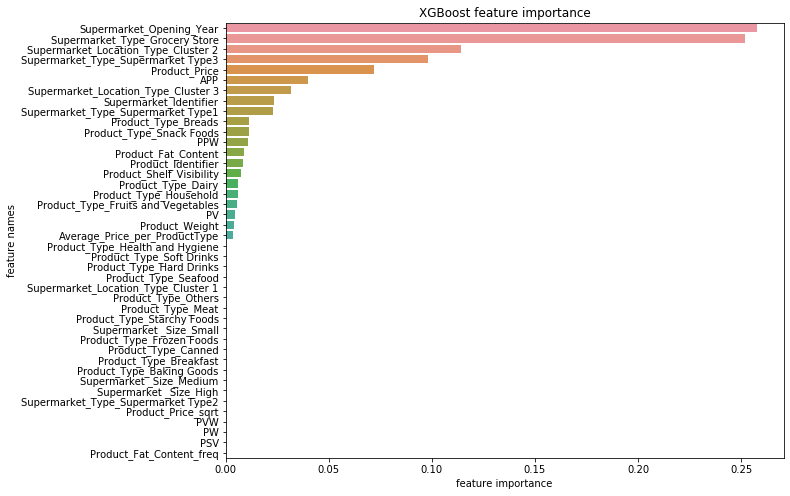

In [294]:
plot_feature_importance(xgb_model.feature_importances_, my_train.columns, 'XGBoost')

In [125]:
to_drop = ['PSV', 'PW', 'Product_Fat_Content_freq', 'Supermarket _Size_freq', 'Supermarket_Location_Type_freq', 'Supermarket_Location_Type']

In [146]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)

KeyError: "['PSV' 'PW' 'Product_Fat_Content_freq' 'Supermarket _Size_freq'\n 'Supermarket_Location_Type_freq' 'Supermarket_Location_Type'] not found in axis"

In [128]:
train.head()

,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Type,Average_Price_per_ProductType,Product_Supermarket_Sales,PPW,APP,PV,PVW,Product_Type_freq,Supermarket_Type_freq
0,10.500,0,0.027276,0,428.28,2004,0,0,399.999418,8983.31,4496.94000,0.933967,11.681941,122.660379,0.116566,0.664329
1,10.000,0,0.045928,1,345.30,2006,1,0,388.071094,4893.63,3453.00000,1.123866,15.859017,158.590175,0.094188,0.664329
2,8.235,0,0.014489,2,459.49,2009,2,0,367.143029,7323.80,3783.90015,0.799023,6.657549,54.824918,0.062458,0.664329
3,18.850,0,0.016108,2,324.41,2004,0,0,367.143029,7541.85,6115.12850,1.131725,5.225450,98.499732,0.062458,0.664329
4,12.600,1,0.074070,3,635.59,2009,2,0,409.504343,11445.10,8008.43400,0.644290,47.078374,593.187517,0.064462,0.664329


In [295]:
fea_pred = xgb_model_2.predict(X_test)

In [296]:
print(np.sqrt(mean_squared_error(y_test, fea_pred)))

3085.3175784847786


In [297]:
fea_final = xgb_model_2.predict(test)

In [298]:
submit['Product_Supermarket_Sales'] = fea_final

In [299]:
submit.to_csv('fea_sub_2.csv', index=False)

In [153]:
len(train.columns)

16

In [154]:
len(test.columns)

15

In [149]:
train.head(2)

,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Type,Average_Price_per_ProductType,Product_Supermarket_Sales,PPW,APP,PV,PVW,Product_Type_freq,Supermarket_Type_freq
0,10.5,0,0.027276,0,428.28,2004,0,0,399.999418,8983.31,4496.94,0.933967,11.681941,122.660379,0.116566,0.664329
1,10.0,0,0.045928,1,345.30,2006,1,0,388.071094,4893.63,3453.00,1.123866,15.859017,158.590175,0.094188,0.664329


In [150]:
test.head(2)

,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Average_Price_per_ProductType,PPW,APP,PSV,PW,PV,PVW,Product_Fat_Content_freq,Product_Type_freq,Supermarket _Size_freq,Supermarket_Location_Type_freq,Supermarket_Type_freq
0,20.2,0,0.121153,0,243.44,1994,0,0,0,395.35219,4917.488,1.624023,12.115333,4917.488,29.493567,595.770051,0.239145,0.102872,0.268203,0.257515,0.439212
1,17.6,1,0.049268,0,282.54,2016,1,0,1,395.35219,4972.704,1.399279,4.926776,4972.704,13.920113,244.993982,0.404142,0.102872,0.214095,0.257515,0.067468


In [151]:
test_drop = ['PSV', 'PW', 'Supermarket_Location_Type', 'Product_Fat_Content_freq', 'Supermarket _Size_freq', 'Supermarket_Location_Type_freq']

In [152]:
test.drop(test_drop, axis=1, inplace=True)